In [1]:
#import statements
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Cleaning the data for modeling:

In [2]:
#reding in data csv file
data = pd.read_csv("Final_Property_Features_Data.csv")

In [3]:
#filling na cols with mean or median col values
data['Stories'] = data['Stories'].fillna(data['Stories'].median())
data['Lot Area'] = data['Lot Area'].fillna(data['Lot Area'].mean())
data['beds'] = data['beds'].fillna(data['beds'].mean())
data['baths'] = data['baths'].fillna(data['baths'].mean())
data['Year Built'] = data['Year Built'].fillna(data['Year Built'].median())

Text(0, 0.5, 'Property Price')

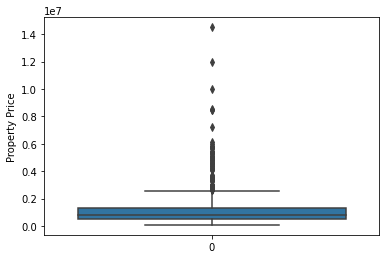

In [9]:
#visualizing outlier prices
sns.boxplot(data['price'])
plt.ylabel("Property Price")

In [10]:
#removing outlier prices
data = data[data['price'] < 2500000]

In [11]:
#dropping rows with nan price values
data = data.dropna(subset=['price'])

In [12]:
#binary encoding Zip Code
mlb = MultiLabelBinarizer()
zip_cols = mlb.fit_transform(data['Zip Code'].astype(str))
zip_df = pd.DataFrame(zip_cols)
zip_df.columns = ["zip_1","zip_2","zip_3","zip_4","zip_5","zip_6","zip_7","zip_8","zip_9","zip_10","zip_11","zip_12"]
data.reset_index(drop=True, inplace=True)
data = pd.concat([data, zip_df], axis=1).drop('Zip Code', axis=1)

In [13]:
#one hot encoding propery type
one_hot_encode_property = pd.get_dummies(data["Property Type"], prefix='Property')
data = pd.concat([data, one_hot_encode_property ], axis=1).drop('Property Type', axis=1)

In [14]:
#one hot encoding borough
one_hot_encode_property = pd.get_dummies(data["Borough"], prefix='Borough')
data = pd.concat([data, one_hot_encode_property ], axis=1).drop('Borough', axis=1)

In [15]:
#defining features array and output price array
x = data.loc[:, ~data.columns.isin(['price','links'])]
y = data["price"]

In [24]:
y

0        358000.0
1       1950000.0
2        159000.0
3         85000.0
4        119000.0
          ...    
1022    1350000.0
1023     739000.0
1024     689000.0
1025    1250000.0
1026    1225000.0
Name: price, Length: 1027, dtype: float64

In [33]:
X_test, X_train, y_test, y_train = [], [], [], []
for ind, data in enumerate(x.iterrows()):
  if ind % 5 == 0:
    X_test.append(data)
    y_test.append(y[ind])
  else:
    X_train.append(data)
    y_train.append(y[ind])

In [34]:
#make into np arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

<ipython-input-34-a6ffd1254a8b>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
<ipython-input-34-a6ffd1254a8b>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_test)


Training a random forest regressor to predict property price:

In [147]:
#defining and fitting random forest model
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)  

RandomForestRegressor(random_state=0)

In [148]:
#evaluating random forest on train and test data
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

Text(0.5, 1.0, 'True vs. Predicted House Prices')

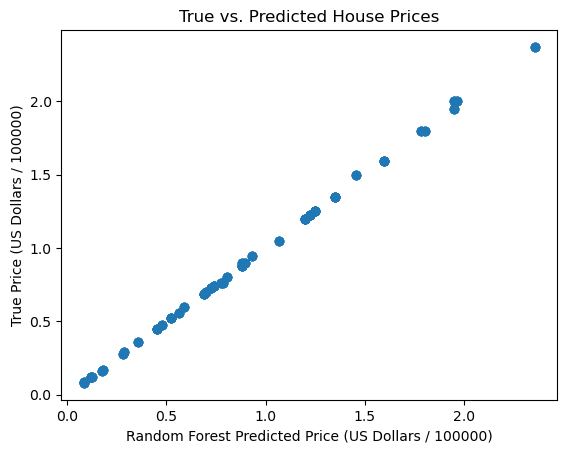

In [149]:
#plotting true vs. model predicitons 
fig = plt.scatter(y_pred_test/1000000,y_test/1000000)
plt.xlabel("Random Forest Predicted Price (US Dollars / 100000)")
plt.ylabel("True Price (US Dollars / 100000)")
plt.title("True vs. Predicted House Prices")

In [150]:
#evaluating metrics
print('Train AE : %.3f'%mean_absolute_error(y_train, y_pred_train))
print('Test AE : %.3f'%mean_absolute_error(y_test, y_pred_test))

print('Train R^2     : %.3f'%r2_score(y_train, y_pred_train))
print('Test R^2     : %.3f'%r2_score(y_test, y_pred_test))

Train AE : 72729.387
Test AE : 6391.566
Train R^2     : 0.952
Test R^2     : 1.000


Text(0.5, 1.0, 'Feature Importance')

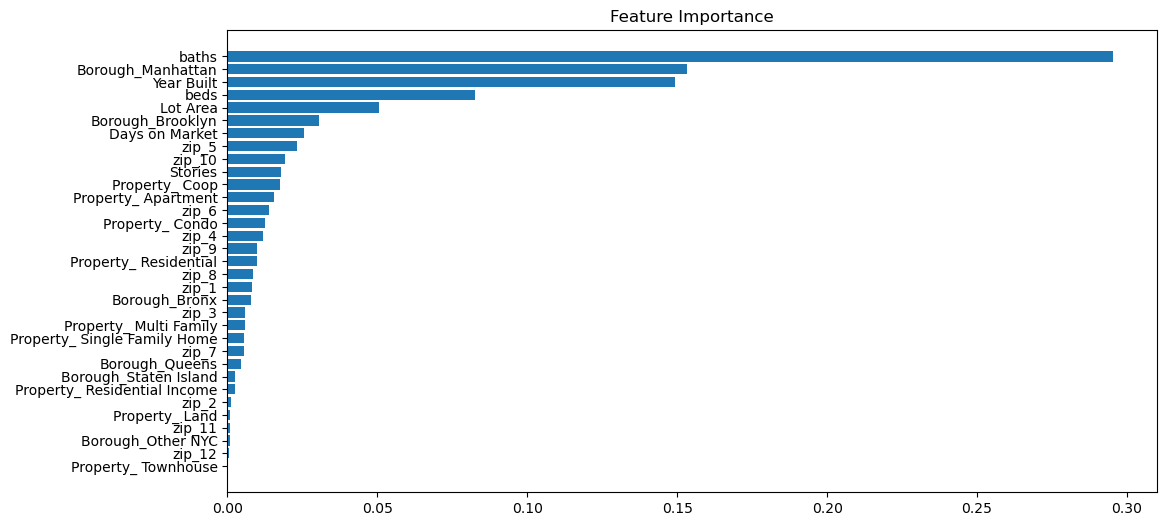

In [151]:
#plotting feature importance
feature_importance = regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('white')
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [152]:
#getting difference between true and predcited price and appending difference column to original pandas data frame
#the lower the difference value, theoretically, the more undervalues the house
diff = []
[diff.append(y_train[i] - y_pred_test[i]) for i in range(len(y_pred_test))]
    
pred_df = data[-len(X_test):]
pred_df["Predicted_Difference"]= diff
pred_df = pred_df.sort_values(by = 'Predicted_Difference')

/var/folders/yj/q_gg81991dx6kj_zmbmk1w2c0000gn/T/ipykernel_15443/1925634661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df["Predicted_Difference"]= diff


In [153]:
pred_df

,links,Stories,beds,baths,price,Days on Market,Year Built,Lot Area,zip_1,zip_2,...,Property_ Residential Income,Property_ Single Family Home,Property_ Townhouse,Borough_Bronx,Borough_Brooklyn,Borough_Manhattan,Borough_Other NYC,Borough_Queens,Borough_Staten Island,Predicted_Difference
847,https://www.trulia.com/p/ny/brooklyn/734-53rd-...,2.0,6.0,4.0,1999000.0,1.0,1908.0,2003.000000,1,1,...,0,0,0,0,1,0,0,0,0,-1672280.0
898,https://www.trulia.com/p/ny/brooklyn/734-53rd-...,2.0,6.0,4.0,1999000.0,1.0,1908.0,2003.000000,1,1,...,0,0,0,0,1,0,0,0,0,-1672280.0
996,https://www.trulia.com/p/ny/new-york/695-1st-a...,2.0,2.0,3.0,2370000.0,1.0,2019.0,38537.693726,1,1,...,0,0,0,0,0,1,0,0,0,-1662350.0
825,https://www.trulia.com/p/ny/brooklyn/123-pierr...,2.0,2.0,2.0,1595000.0,1.0,1849.0,38537.693726,1,1,...,0,0,0,0,1,0,0,0,0,-1476000.0
876,https://www.trulia.com/p/ny/brooklyn/123-pierr...,2.0,2.0,2.0,1595000.0,1.0,1849.0,38537.693726,1,1,...,0,0,0,0,1,0,0,0,0,-1476000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011,https://www.trulia.com/p/ny/new-york/26-w-127t...,2.0,1.0,1.0,760000.0,1.0,2022.0,38537.693726,1,1,...,0,0,0,0,0,1,0,0,0,1587885.0
865,https://www.trulia.com/p/ny/brooklyn/1558-e-19...,2.0,1.0,1.0,119000.0,11.0,1940.0,38537.693726,1,1,...,0,0,0,0,1,0,0,0,0,1674912.0
916,https://www.trulia.com/p/ny/brooklyn/1558-e-19...,2.0,1.0,1.0,119000.0,11.0,1940.0,38537.693726,1,1,...,0,0,0,0,1,0,0,0,0,1674912.0
1023,https://www.trulia.com/p/ny/staten-island/131-...,2.0,3.0,2.0,739000.0,1.0,1920.0,3600.000000,1,1,...,0,0,0,0,0,0,0,0,1,1746000.0


Training a vanilla neaural network to predict property price

In [154]:
#defining and compiling model
model = Sequential([
    Dense(len(data.columns), activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam',
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])

In [155]:
#fitting neural network
#my_callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train, y_train, epochs = 1000, validation_split=0.2)

Epoch 1/1000


2022-12-07 20:35:30.737319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 872971.7500 - mean_absolute_error: 872971.7500

2022-12-07 20:35:31.294725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 23ms/step - loss: 872971.7500 - mean_absolute_error: 872971.7500 - val_loss: 770920.3125 - val_mean_absolute_error: 770920.3125
Epoch 2/1000
21/21 [==============================] - 0s 6ms/step - loss: 803544.3125 - mean_absolute_error: 803544.3125 - val_loss: 795426.5625 - val_mean_absolute_error: 795426.5625
Epoch 3/1000
21/21 [==============================] - 0s 6ms/step - loss: 758000.0625 - mean_absolute_error: 758000.0625 - val_loss: 821238.4375 - val_mean_absolute_error: 821238.4375
Epoch 4/1000
21/21 [==============================] - 0s 6ms/step - loss: 756979.5625 - mean_absolute_error: 756979.5625 - val_loss: 828219.9375 - val_mean_absolute_error: 828219.9375
Epoch 5/1000
21/21 [==============================] - 0s 6ms/step - loss: 735244.1875 - mean_absolute_error: 735244.1875 - val_loss: 773742.1250 - val_mean_absolute_error: 773742.1250
Epoch 6/1000
21/21 [==============================] - 0s 6ms/step - loss: 712949.3125 - mean

In [156]:
#evaluating neural network
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 27ms/step - loss: 267923.8750 - mean_absolute_error: 267923.8750


[267923.875, 267923.875]

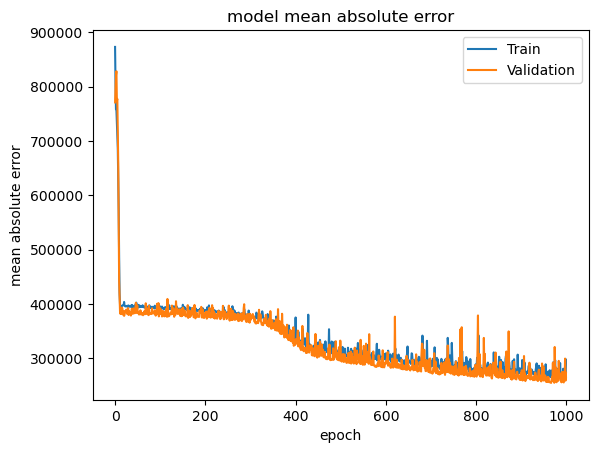

In [157]:
plt.plot(history.history['mean_absolute_error']);plt.plot(history.history['val_mean_absolute_error']);plt.title('model mean absolute error');plt.ylabel('mean absolute error');plt.xlabel('epoch');plt.legend(['Train', 'Validation'], loc='upper right')

Training a linear regression to predict property price:

In [158]:
#defining and training linear regression model
regression = LinearRegression()
regression.fit(X_train, y_train)

LinearRegression()

In [159]:
#predicting on train/test data
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

Text(0.5, 1.0, 'True vs. Predicted House Prices')

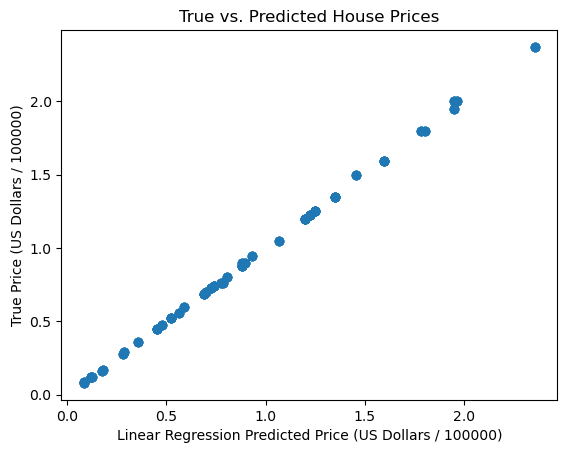

In [160]:
#plotting preds vs. true
fig = plt.scatter(y_pred_test/1000000,y_test/1000000)
plt.xlabel("Linear Regression Predicted Price (US Dollars / 100000)")
plt.ylabel("True Price (US Dollars / 100000)")
plt.title("True vs. Predicted House Prices")

In [161]:
#evaluating metrics
print('Train AE : %.3f'%mean_absolute_error(y_train, y_pred_train))
print('Test AE : %.3f'%mean_absolute_error(y_test, y_pred_test))

print('Train R^2     : %.3f'%r2_score(y_train, y_pred_train))
print('Test R^2     : %.3f'%r2_score(y_test, y_pred_test))

Train AE : 72729.387
Test AE : 6391.566
Train R^2     : 0.952
Test R^2     : 1.000
